# Description 
This notebook mainly provides the code basis for answering the following research questions:

        2) How can formulaicity be measured?
                a) How formulaic are charters compared to other texts?
                b) Has formulaicity in charters changed over time, and if so, how?

# Imports and settings

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import ttest_ind
from lexicalrichness import LexicalRichness
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

In [2]:
from formutils import *

In [3]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [4]:
plt.style.use(["bmh", "plot.mplstyle"])
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [5]:
df_merged = pd.read_json("../data-push/0d-sampling/df-merged.json", encoding="utf-8")
df_merged_nopunct = pd.read_json("../data-push/0d-sampling/df-merged-nopunct.json", encoding="utf-8")

# What is the texts' shared vocabulary?

In [6]:
df_merged_nopunct_vocab = df_merged_nopunct.copy()
df_merged_nopunct_vocab_no_charters = df_merged_nopunct[df_merged_nopunct["category"] != "Charter"]
df_merged_nopunct_vocab_charters = df_merged_nopunct[df_merged_nopunct["category"] == "Charter"].sample(
    n=50, random_state=42
)
df_merged_nopunct_vocab = pd.concat([df_merged_nopunct_vocab_no_charters, df_merged_nopunct_vocab_charters])

In [7]:
df_merged_nopunct_vocab["words"] = df_merged_nopunct_vocab["text"].apply(lambda x: nltk.word_tokenize(x.lower()))

In [8]:
categories = list(df_merged_nopunct_vocab["category"].unique())

In [9]:
word_counts = {}
for category in categories:
    category_df = df_merged_nopunct_vocab[df_merged_nopunct_vocab["category"] == category]
    category_words = []
    for tokens in category_df["words"]:
        category_words += tokens
    word_counts[category] = Counter(category_words)

In [10]:
vocabulary_sizes = {}
for category, counts in word_counts.items():
    vocabulary_sizes[category] = len(counts.keys())

In [11]:
vocabulary_sizes

{'Biblical poetry': 13536,
 'Didactic poetry': 10683,
 'Legend': 15389,
 'Miscellaneous': 16933,
 'Prayer': 4680,
 'Translation': 11526,
 'Epic': 12800,
 'Recipe': 3238,
 'Sermon': 11929,
 'Charter': 3688}

In [12]:
vocabulary_sizes_df = dict_to_dataframe(vocabulary_sizes, columns=["Category", "Count"])
vocabulary_sizes_df

,Category,Count
0,Biblical poetry,13536
1,Didactic poetry,10683
2,Legend,15389
3,Miscellaneous,16933
4,Prayer,4680
5,Translation,11526
6,Epic,12800
7,Recipe,3238
8,Sermon,11929
9,Charter,3688


In [13]:
cat_df = df_merged_nopunct_vocab.category.value_counts().to_frame().reset_index()
cat_df.columns = ["Category", "Number"]
cat_df

,Category,Number
0,Prayer,74
1,Miscellaneous,55
2,Charter,50
3,Biblical poetry,49
4,Legend,43
5,Sermon,33
6,Didactic poetry,32
7,Epic,25
8,Translation,22
9,Recipe,13


In [14]:
vocabulary_sizes_df = cat_df.merge(vocabulary_sizes_df, on="Category")
vocabulary_sizes_df = vocabulary_sizes_df.sort_values(by="Count", ascending=False)
vocabulary_sizes_df

,Category,Number,Count
1,Miscellaneous,55,16933
4,Legend,43,15389
3,Biblical poetry,49,13536
7,Epic,25,12800
5,Sermon,33,11929
8,Translation,22,11526
6,Didactic poetry,32,10683
0,Prayer,74,4680
2,Charter,50,3688
9,Recipe,13,3238


In [15]:
#vocabulary_sizes_df.to_latex("../data-push/2-formulaicity/category-vocabulary-sizes.tex", index=False, column_format="l r S[table-format=4]")

In [16]:
all_words = set()
for tokens in df_merged_nopunct_vocab["words"]:
    all_words.update(set(tokens))

In [17]:
category_word_counts = {}
for category in categories:
    category_df = df_merged_nopunct_vocab[df_merged_nopunct_vocab["category"] == category]
    category_words = []
    for tokens in category_df["words"]:
        category_words += tokens
    category_word_counts[category] = Counter([word.lower() for word in category_words])

In [18]:
contingency_table = pd.DataFrame(columns=categories, index=categories)

In [19]:
for i in range(len(categories)):
    for j in range(len(categories)):
        category_i = categories[i]
        category_j = categories[j]
        overlap = len(set(category_word_counts[category_i].keys()) & set(category_word_counts[category_j].keys()))
        total_i = len(category_word_counts[category_i].keys())
        total_j = len(category_word_counts[category_j].keys())
        if total_i == 0 or total_j == 0:
            contingency_table.loc[category_i, category_j] = 0.0
        else:
            contingency_table.loc[category_i, category_j] = overlap / ((total_i + total_j) / 2) * 100

contingency_table = contingency_table.round(0).astype(int)

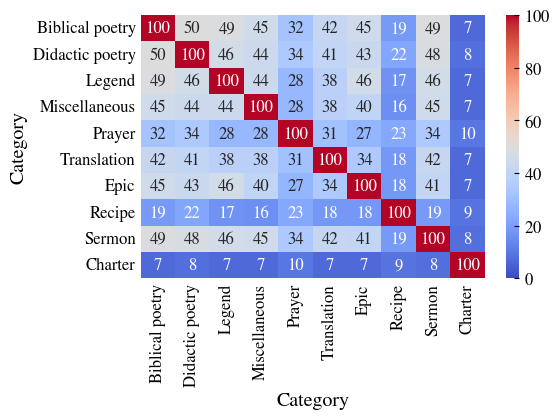

In [20]:
sns.heatmap(contingency_table, cmap="coolwarm", annot=True, fmt="1", vmin=0, vmax=100)
plt.xlabel("Category")
plt.ylabel("Category")
plt.grid(False)
plt.tick_params(axis="both", which="both", length=0, width=0)
plt.savefig("../data-push/2-formulaicity/category-category-heatmap.pdf", format="pdf", bbox_inches="tight")

# How is character usage distributed across categories?

Character distribution for full frame

In [21]:
char_distribution = df_merged
char_distribution["char_freq"] = char_distribution["text"].apply(count_characters)

In [22]:
char_distribution = df_merged

char_distribution["char_freq"] = char_distribution["text"].apply(count_characters)

mean_char_distribution = (
    char_distribution.groupby("category")["char_freq"]
    .apply(lambda x: pd.DataFrame(x.tolist()).mean().to_dict())
    .unstack()  # anti multi-index
    .sort_index(axis=1)
    .transpose()  # axis swap
)

mean_char_distribution.style.highlight_max(axis=1)

category,Biblical poetry,Charter,Didactic poetry,Epic,Legend,Miscellaneous,Prayer,Recipe,Sermon,Translation
,0.179605,0.167788,0.177762,0.183739,0.181256,0.175518,0.174752,0.174267,0.177481,0.177775
",",0.000315,0.011641,nan,0.000426,nan,0.000548,0.000390,nan,0.000036,nan
.,0.029276,0.003305,0.031283,0.020652,0.023166,0.032228,0.037229,0.048202,0.026559,0.024596
:,0.000285,0.000603,0.000514,nan,nan,nan,0.000031,nan,0.000351,0.000042
;,0.000056,0.000723,0.000099,0.000037,0.000087,0.000035,0.005019,nan,0.000305,0.008475
a,0.044960,0.050148,0.042466,0.049806,0.047024,0.042326,0.040825,0.035283,0.041023,0.035444
b,0.013753,0.017506,0.013705,0.012171,0.012577,0.014326,0.015905,0.013453,0.012189,0.012776
c,0.019264,0.025210,0.016979,0.021632,0.020330,0.018585,0.020006,0.015393,0.017830,0.017040
d,0.048714,0.048285,0.048322,0.044468,0.046322,0.049256,0.051669,0.053361,0.049012,0.057399
e,0.151305,0.125975,0.157526,0.147857,0.152864,0.153039,0.148457,0.147885,0.158930,0.160914


In [23]:
char_distribution = df_merged_nopunct
char_distribution["char_freq"] = char_distribution["text"].apply(count_characters)

mean_char_distribution = (
    char_distribution.groupby("category")["char_freq"]
    .apply(lambda x: pd.DataFrame(x.tolist()).mean().to_dict())
    .unstack()  # anti multi-index
    .sort_index(axis=1)
    .transpose()  # axis swap
)

mean_char_distribution.style.highlight_max(axis=1)

category,Biblical poetry,Charter,Didactic poetry,Epic,Legend,Miscellaneous,Prayer,Recipe,Sermon,Translation
,0.184598,0.170354,0.183554,0.187492,0.185450,0.181447,0.181375,0.182968,0.182344,0.182391
a,0.046191,0.050910,0.043841,0.050809,0.048100,0.043756,0.042409,0.036917,0.042131,0.036403
b,0.014142,0.017774,0.014150,0.012413,0.012866,0.014791,0.016526,0.014193,0.012522,0.013105
c,0.019810,0.025591,0.017504,0.022074,0.020791,0.019184,0.020783,0.016142,0.018308,0.017470
d,0.050043,0.049022,0.049870,0.045373,0.047381,0.050974,0.053545,0.055912,0.050350,0.058910
e,0.155512,0.127897,0.162625,0.150864,0.156434,0.158128,0.153859,0.155499,0.163301,0.164968
f,0.002969,0.011661,0.003649,0.003559,0.003235,0.004500,0.004734,0.003953,0.002881,0.004529
g,0.022444,0.027674,0.021604,0.020617,0.021677,0.020651,0.025229,0.018039,0.021017,0.023370
h,0.031985,0.041757,0.028380,0.034114,0.033202,0.031261,0.033589,0.023925,0.030854,0.033992
i,0.073152,0.056866,0.075172,0.072353,0.072614,0.069684,0.072621,0.072702,0.071243,0.072211


Character usage for sub set

In [24]:
non_charters_nopunct = df_merged_nopunct[df_merged_nopunct["category"] != "Charter"]
charters_nopunct = df_merged_nopunct[df_merged_nopunct["category"] == "Charter"].sample(n=50, random_state=42)
df_nopunct = pd.concat([non_charters_nopunct, charters_nopunct])
df_nopunct["text"] = df_nopunct["text"].apply(lambda x: x.lower())

In [25]:
char_distribution_equalized = df_nopunct

char_distribution_equalized["char_freq"] = char_distribution_equalized["text"].apply(count_characters)

mean_char_distribution_equalized = (
    char_distribution_equalized.groupby("category")["char_freq"]
    .apply(lambda x: pd.DataFrame(x.tolist()).mean().to_dict())
    .unstack()  # anti multi-index
    .sort_index(axis=1)
    .transpose()  # axis swap
)

mean_char_distribution_equalized.style.highlight_max(axis=1)

category,Biblical poetry,Charter,Didactic poetry,Epic,Legend,Miscellaneous,Prayer,Recipe,Sermon,Translation
,0.184598,0.170387,0.183554,0.187492,0.185450,0.181447,0.181375,0.182968,0.182344,0.182391
a,0.046191,0.050845,0.043841,0.050809,0.048100,0.043756,0.042409,0.036917,0.042131,0.036403
b,0.014142,0.017041,0.014150,0.012413,0.012866,0.014791,0.016526,0.014193,0.012522,0.013105
c,0.019810,0.025831,0.017504,0.022074,0.020791,0.019184,0.020783,0.016142,0.018308,0.017470
d,0.050043,0.049663,0.049870,0.045373,0.047381,0.050974,0.053545,0.055912,0.050350,0.058910
e,0.155512,0.128961,0.162625,0.150864,0.156434,0.158128,0.153859,0.155499,0.163301,0.164968
f,0.002969,0.011958,0.003649,0.003559,0.003235,0.004500,0.004734,0.003953,0.002881,0.004529
g,0.022444,0.026428,0.021604,0.020617,0.021677,0.020651,0.025229,0.018039,0.021017,0.023370
h,0.031985,0.042382,0.028380,0.034114,0.033202,0.031261,0.033589,0.023925,0.030854,0.033992
i,0.073152,0.057363,0.075172,0.072353,0.072614,0.069684,0.072621,0.072702,0.071243,0.072211


# How are lexical diversity measures distributed across categories?

Implement lower treshold for word counts to accommodate different text amounts and lengths

In [26]:
total = df_merged_nopunct.category.value_counts()
small = (
    df_merged_nopunct[df_merged_nopunct["tokens"] >= 50]
    .sort_values("tokens", ascending=True).category
    .value_counts()
)

medium = (
    df_merged_nopunct[df_merged_nopunct["tokens"] >= 100]
    .sort_values("tokens", ascending=True).category
    .value_counts()
)

result = pd.concat([total, small, medium], axis=1)
result = result.reset_index()
result.columns = ["Categories", "Total", ">= 50", ">= 100"]
#result.to_latex("../data-push/2-formulaicity/threshold-token-distribution.tex", index=False, column_format="l S[table-format=4] S[table-format=4] S[table-format=4]")
result

,Categories,Total,>= 50,>= 100
0,Charter,7286,7273,7156
1,Prayer,74,52,34
2,Miscellaneous,55,52,46
3,Biblical poetry,49,48,48
4,Legend,43,43,43
5,Sermon,33,33,33
6,Didactic poetry,32,28,27
7,Epic,25,25,25
8,Translation,22,21,20
9,Recipe,13,11,11


Using data set without punctuation

In [27]:
df_inliers = df_merged_nopunct[df_merged_nopunct["tokens"] >= 100]

Re-sample after set threshold

In [28]:
non_charters_nopunct = df_inliers[df_inliers["category"] != "Charter"]
charters_nopunct = df_inliers[df_inliers["category"] == "Charter"].sample(n=50, random_state=42)
df_nopunct = pd.concat([non_charters_nopunct, charters_nopunct])
df_nopunct["text"] = df_nopunct["text"].apply(lambda x: x.lower())

Calculate lexical diversity measures

In [29]:
ld_measures = [
    "RTTR",
    "MATTR",  # 👑
    "MTLD",  # 👑
    "HDD",
    "Dugast",
]

In [30]:
lr = df_nopunct["text"].apply(LexicalRichness)

In [31]:
df_nopunct["RTTR"] = lr.progress_apply(lambda x: x.rttr)
df_nopunct["MATTR"] = lr.progress_apply(lambda x: x.mattr(window_size=25))
df_nopunct["MTLD"] = lr.progress_apply(lambda x: x.mtld(threshold=0.72)) #takes 2-3 min
df_nopunct["HDD"] = lr.progress_apply(lambda x: x.hdd(draws=42))
df_nopunct["Dugast"] = lr.progress_apply(lambda x: x.Dugast)

  0%|          | 0/337 [00:00<?, ?it/s]

  0%|          | 0/337 [00:00<?, ?it/s]

  0%|          | 0/337 [00:00<?, ?it/s]

  0%|          | 0/337 [00:00<?, ?it/s]

  0%|          | 0/337 [00:00<?, ?it/s]

# Do lexical diversity measures correlate?

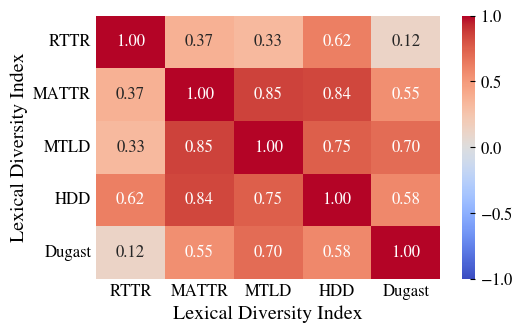

In [32]:
corr = df_nopunct[ld_measures].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.xlabel("Lexical Diversity Index")
plt.ylabel("Lexical Diversity Index")
plt.grid(False)
plt.tick_params(axis="both", which="both", length=0, width=0)
plt.savefig("../data-push/2-formulaicity/ld-ld-heatmap.pdf", format="pdf", bbox_inches="tight")

# How formulaic are texts with regards to lexical diversity measures?

Using minimum highlights

In [33]:
mean_df_list = [df_nopunct.groupby("category")[col].mean() for col in ld_measures]

mean_df = pd.concat(mean_df_list, axis=1).transpose()
mean_df.style.highlight_min(axis=1)

category,Biblical poetry,Charter,Didactic poetry,Epic,Legend,Miscellaneous,Prayer,Recipe,Sermon,Translation
RTTR,14.872865,9.878091,15.017461,17.046988,16.101752,13.596035,10.361964,10.197565,14.908918,15.952743
MATTR,0.891428,0.879401,0.871535,0.904717,0.896956,0.851767,0.823139,0.811797,0.866928,0.845085
MTLD,104.546416,91.183285,88.429723,112.909580,113.040583,68.032839,54.676740,46.080503,77.051835,63.949868
HDD,0.872626,0.843053,0.861515,0.883907,0.878326,0.834024,0.816170,0.773697,0.861285,0.843507
Dugast,57.278676,54.456067,54.010072,52.455032,57.608840,48.434274,48.573610,44.881167,51.195800,51.817285


Using maximum highlights

In [34]:
mean_df_list = [df_nopunct.groupby("category")[col].mean() for col in ld_measures]

mean_df = pd.concat(mean_df_list, axis=1).transpose()
mean_df.style.highlight_max(axis=1)

category,Biblical poetry,Charter,Didactic poetry,Epic,Legend,Miscellaneous,Prayer,Recipe,Sermon,Translation
RTTR,14.872865,9.878091,15.017461,17.046988,16.101752,13.596035,10.361964,10.197565,14.908918,15.952743
MATTR,0.891428,0.879401,0.871535,0.904717,0.896956,0.851767,0.823139,0.811797,0.866928,0.845085
MTLD,104.546416,91.183285,88.429723,112.909580,113.040583,68.032839,54.676740,46.080503,77.051835,63.949868
HDD,0.872626,0.843053,0.861515,0.883907,0.878326,0.834024,0.816170,0.773697,0.861285,0.843507
Dugast,57.278676,54.456067,54.010072,52.455032,57.608840,48.434274,48.573610,44.881167,51.195800,51.817285


Transpose

In [35]:
mean_df_list = [df_nopunct.groupby("category")[col].mean() for col in ld_measures]

mean_df = pd.concat(mean_df_list, axis=1).reset_index()
#mean_df.to_latex("../data-push/2-formulaicity/ld-category-mean.tex", index=False, float_format="%.2f") #column_format="l S[table-format=4] S[table-format=4] S[table-format=4]")
mean_df

,category,RTTR,MATTR,MTLD,HDD,Dugast
0,Biblical poetry,14.872865,0.891428,104.546416,0.872626,57.278676
1,Charter,9.878091,0.879401,91.183285,0.843053,54.456067
2,Didactic poetry,15.017461,0.871535,88.429723,0.861515,54.010072
3,Epic,17.046988,0.904717,112.909580,0.883907,52.455032
4,Legend,16.101752,0.896956,113.040583,0.878326,57.608840
5,Miscellaneous,13.596035,0.851767,68.032839,0.834024,48.434274
6,Prayer,10.361964,0.823139,54.676740,0.816170,48.573610
7,Recipe,10.197565,0.811797,46.080503,0.773697,44.881167
8,Sermon,14.908918,0.866928,77.051835,0.861285,51.195800
9,Translation,15.952743,0.845085,63.949868,0.843507,51.817285


## How different are the categories regarding textual properties, i.e., text measures?

In [36]:
mean_length = df_nopunct.groupby("category")["length"].mean()
mean_tokens = df_nopunct.groupby("category")["tokens"].mean()
mean_types = df_nopunct.groupby("category")["types"].mean()

mean_values = pd.concat([mean_length, mean_tokens, mean_types], axis=1)
mean_values = mean_values
mean_values.columns = "mean_length", "mean_tokens", "mean_types"
mean_values = mean_values.sort_values(by="mean_tokens", ascending=False).round(0).astype(int).reset_index()
#mean_values.to_latex("../data-push/2-formulaicity/text-category-mean.tex", index=False, column_format="l S[table-format=4] S[table-format=4] S[table-format=4]") # float_format="%.0f")
mean_values

,category,mean_length,mean_tokens,mean_types
0,Epic,45133,8388,1501
1,Translation,38722,6979,1323
2,Miscellaneous,31552,5713,1016
3,Legend,28295,5206,1124
4,Sermon,28008,5075,1030
5,Didactic poetry,25163,4622,1002
6,Biblical poetry,21377,3952,885
7,Recipe,11945,2234,452
8,Prayer,5606,990,321
9,Charter,2435,416,200


# Are text measures correlated with lexical diversity measures?

In [37]:
text_measures = ["length", "types", "tokens"]

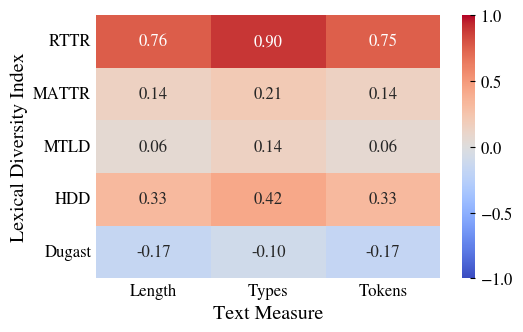

In [38]:
length_corr_df = pd.DataFrame(columns=ld_measures)
tokens_corr_df = pd.DataFrame(columns=ld_measures)
types_corr_df = pd.DataFrame(columns=ld_measures)

for col in text_measures:
    df_subset = df_nopunct[[col] + ld_measures]
    corr_matrix = df_subset.corr()
    correlations = corr_matrix[col][ld_measures]
    if col == "length":
        length_corr_df = correlations
    elif col == "types":
        types_corr_df = correlations
    elif col == "tokens":
        tokens_corr_df = correlations

result_df = pd.concat([length_corr_df, types_corr_df, tokens_corr_df], axis=1)
result_df_sns = result_df
result_df_sns.columns = ["Length", "Types", "Tokens"]
result_df_sns
sns.heatmap(result_df_sns, annot=True, cmap="coolwarm", fmt=".2f", center=0, vmin=-1, vmax=1)
plt.xlabel("Text Measure")
plt.ylabel("Lexical Diversity Index")
plt.tick_params(axis="both", which="both", length=0, width=0)
plt.grid(False)
plt.savefig("../data-push/2-formulaicity/text-ld-heatmap.pdf", format="pdf", bbox_inches="tight")
plt.show()

# How formulaic are texts in terms of compression ratio?

In [39]:
compression_ratios = ["GZIP", "BZ2", "LZMA"]

In [40]:
df_nopunct["GZIP"] = df_nopunct["text"].apply(lambda x: get_compression_ratio(x, "gzip"))
df_nopunct["BZ2"] = df_nopunct["text"].apply(lambda x: get_compression_ratio(x, "bz2"))
df_nopunct["LZMA"] = df_nopunct["text"].apply(lambda x: get_compression_ratio(x, "lzma"))

In [41]:
compression_df_list = [df_nopunct.groupby("category")[col].mean() for col in compression_ratios]
compression_df_list = pd.concat(compression_df_list, axis=1).transpose()
compression_df_list.style.highlight_max(axis=1)

category,Biblical poetry,Charter,Didactic poetry,Epic,Legend,Miscellaneous,Prayer,Recipe,Sermon,Translation
GZIP,0.406993,0.428680,0.385571,0.371771,0.392817,0.357003,0.386500,0.401284,0.367563,0.361144
BZ2,0.371424,0.418506,0.350635,0.320958,0.352678,0.327829,0.372149,0.386642,0.328343,0.319877
LZMA,0.423144,0.485474,0.398014,0.359885,0.399461,0.370000,0.427603,0.448031,0.366322,0.358808


In [42]:
compression_df_list = [df_nopunct.groupby("category")[col].mean() for col in compression_ratios]
compression_df_list = pd.concat(compression_df_list, axis=1)
compression_df_list = compression_df_list.reset_index()
#compression_df_list.to_latex("../data-push/2-formulaicity/compression-category-mean.tex", index=False, float_format="%.2f") #column_format="l S[table-format=4] S[table-format=4] S[table-format=4]")
compression_df_list

,category,GZIP,BZ2,LZMA
0,Biblical poetry,0.406993,0.371424,0.423144
1,Charter,0.428680,0.418506,0.485474
2,Didactic poetry,0.385571,0.350635,0.398014
3,Epic,0.371771,0.320958,0.359885
4,Legend,0.392817,0.352678,0.399461
5,Miscellaneous,0.357003,0.327829,0.370000
6,Prayer,0.386500,0.372149,0.427603
7,Recipe,0.401284,0.386642,0.448031
8,Sermon,0.367563,0.328343,0.366322
9,Translation,0.361144,0.319877,0.358808


Check compression against reduced version

In [43]:
df_nopunct_reduced = df_nopunct[(df_nopunct["tokens"] >= 100) & (df_nopunct["tokens"] <= 1000)].copy()
df_nopunct_reduced.category.value_counts()

Charter            49
Prayer             24
Biblical poetry    22
Miscellaneous      16
Legend             14
Sermon             12
Didactic poetry     9
Recipe              7
Translation         6
Epic                4
Name: category, dtype: int64

In [44]:
df_nopunct_reduced["GZIP"] = df_nopunct_reduced["text"].apply(lambda x: get_compression_ratio(x, "gzip"))
df_nopunct_reduced["BZ2"] = df_nopunct_reduced["text"].apply(lambda x: get_compression_ratio(x, "bz2"))
df_nopunct_reduced["LZMA"] = df_nopunct_reduced["text"].apply(lambda x: get_compression_ratio(x, "lzma"))

In [45]:
compression_df_list_reduced = [df_nopunct_reduced.groupby("category")[col].mean() for col in compression_ratios]
compression_df_list_reduced = pd.concat(compression_df_list_reduced, axis=1).transpose()
compression_df_list_reduced.style.highlight_max(axis=1)

category,Biblical poetry,Charter,Didactic poetry,Epic,Legend,Miscellaneous,Prayer,Recipe,Sermon,Translation
GZIP,0.448280,0.430714,0.444750,0.431349,0.455555,0.418222,0.404901,0.439500,0.412725,0.425996
BZ2,0.428164,0.420739,0.437386,0.403201,0.437717,0.422268,0.398606,0.438825,0.386835,0.402185
LZMA,0.501285,0.488573,0.515623,0.464560,0.512861,0.491928,0.464292,0.518826,0.439661,0.466914


In [46]:
compression_df_list_reduced = [df_nopunct_reduced.groupby("category")[col].mean() for col in compression_ratios]
compression_df_list_reduced = pd.concat(compression_df_list_reduced, axis=1)
compression_df_list_reduced = compression_df_list_reduced.reset_index()
#compression_df_list_reduced.to_latex("../data-push/2-formulaicity/compression-category-mean-reduced.tex", index=False, float_format="%.2f") #column_format="l S[table-format=4] S[table-format=4] S[table-format=4]")
compression_df_list_reduced

,category,GZIP,BZ2,LZMA
0,Biblical poetry,0.448280,0.428164,0.501285
1,Charter,0.430714,0.420739,0.488573
2,Didactic poetry,0.444750,0.437386,0.515623
3,Epic,0.431349,0.403201,0.464560
4,Legend,0.455555,0.437717,0.512861
5,Miscellaneous,0.418222,0.422268,0.491928
6,Prayer,0.404901,0.398606,0.464292
7,Recipe,0.439500,0.438825,0.518826
8,Sermon,0.412725,0.386835,0.439661
9,Translation,0.425996,0.402185,0.466914


# Do text measures correlate with compression ratios?

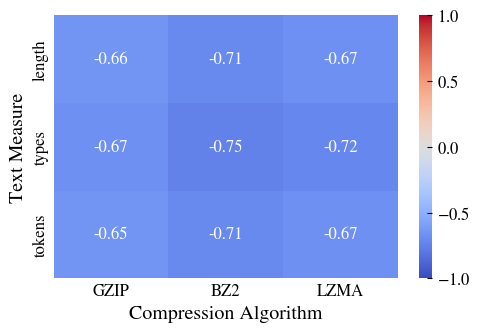

In [47]:
correlations = {}
for col in text_measures:
    df_subset = df_nopunct[[col] + compression_ratios]
    corr_matrix = df_subset.corr()
    correlations[col] = corr_matrix[col][compression_ratios]

result_df = pd.DataFrame(correlations, index=compression_ratios).transpose()

sns.heatmap(result_df, annot=True, cmap="coolwarm", fmt=".2f", center=0, vmin=-1, vmax=1)
plt.xlabel("Compression Algorithm")
plt.ylabel("Text Measure")
plt.grid(False)
plt.show()

# Do lexical diversity measures and compression ratios correlate?

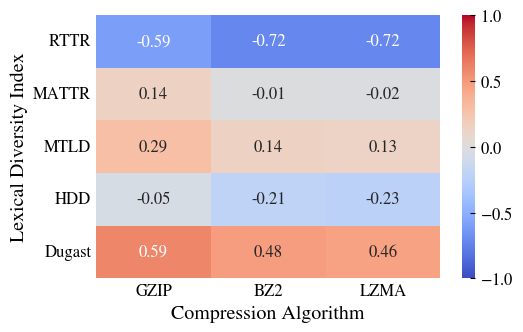

In [48]:
correlations = {}
for col in ld_measures:
    df_subset = df_nopunct[[col] + compression_ratios]
    corr_matrix = df_subset.corr()
    correlations[col] = corr_matrix[col][compression_ratios]

result_df = pd.DataFrame(correlations, index=compression_ratios).transpose()

sns.heatmap(result_df, annot=True, cmap="coolwarm", fmt=".2f", center=0, vmin=-1, vmax=1)
plt.grid(False)
plt.tick_params(axis="both", which="both", length=0, width=0)
plt.xlabel("Compression Algorithm")
plt.ylabel("Lexical Diversity Index")
plt.savefig("../data-push/2-formulaicity/compression-ld-heatmap.pdf", format="pdf", bbox_inches="tight")
plt.show()

# What is the mean n-gram coverage per category?

For this step, a reduced version of the dataframe is taken.

In [49]:
df = df_nopunct_reduced.copy()
df

,id,abstract,text,year,type,category,name,id_old,tokens,types,length,char_freq,RTTR,MATTR,MTLD,HDD,Dugast,GZIP,BZ2,LZMA
2,5c62270a55f4ab4e,None,in werelte aneginne do lieht wart unde stimme ...,NaN,ref,Legend,Annolied (V: Bonaventura Vulcanius),M013B,341,197,1827,"{'i': 0.07443897099069513, 'n': 0.085933223864...",10.668148,0.881767,97.278831,0.867547,61.986824,0.458675,0.439518,0.521073
3,c2cd92fdfb708706,None,er solte ime die kint geben so liez er sinen b...,NaN,ref,Biblical poetry,Halberstädter Makkabäer,M133,575,275,2971,"{'e': 0.15853248064624706, 'r': 0.057556378323...",11.468293,0.907877,102.529388,0.868035,54.742511,0.434197,0.406261,0.471222
6,0aabd936818b965a,None,januarius dicoet ob aquarius enthabe aller vri...,NaN,ref,Miscellaneous,Monatsregeln für die Wahl eines Freundes,M146,277,121,1510,"{'j': 0.001986754966887417, 'a': 0.03377483443...",7.270185,0.886324,61.416290,0.768800,38.189499,0.405298,0.403974,0.471523
12,cc96980ff74a77e3,None,ich geloube an almehtigen der der schepfaere i...,NaN,ref,Prayer,Benediktbeurer Glaube u. Beichte I,M090,411,176,2328,"{'i': 0.06701030927835051, 'c': 0.025773195876...",8.681440,0.809199,37.065205,0.789088,42.710848,0.377577,0.371134,0.419244
13,58c4aa7bd9d5d31d,None,hier bevore en wiste waz leit waere nu bin ich...,NaN,ref,Biblical poetry,Ältere niederrheinische Marienklage,M135,928,389,4920,"{'h': 0.03536585365853658, 'i': 0.085772357723...",12.769551,0.879336,85.098501,0.864225,53.700839,0.413211,0.373984,0.423577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611845,d27ecc3ecf753180,Ulrich von Reichenstein und seine Hausfrau Eli...,ich vlreich von reychenstain vnd ich elspet se...,1330.0,main,Charter,None,"tag:www.monasterium.net,2011:/charter/OOEUB/13...",130,94,743,"{'i': 0.063257065948856, 'c': 0.03499327052489...",8.244345,0.936226,122.302533,0.876078,73.072156,0.511440,0.530283,0.656797
88776,7df76484d347e40b,Friedrich der Zistel von Klosterneuburg verkau...,ich fridreich der zistel purger zu newnburg ch...,1385.0,main,Charter,None,"tag:www.monasterium.net,2011:/charter/AT-StiAG...",657,276,3891,"{'i': 0.05988177846312002, 'c': 0.033410434335...",10.767786,0.895419,87.241193,0.848356,48.530914,0.380879,0.359291,0.404009
612380,371e5ebcb2014402,"Ulrich Guetiar, Bürger zu Gmunden, macht mehr...",ich vlreich guetiar purger ze gemunden vergich...,1359.0,main,Charter,None,"tag:www.monasterium.net,2011:/charter/OOEUB/13...",616,263,3780,"{'i': 0.05502645502645503, 'c': 0.031481481481...",10.596572,0.882905,86.762931,0.849467,48.476612,0.370899,0.360317,0.390476
612594,98f27d9bf3d8f8d7,Wolfker von Dachsperg verkauft dem Grafen Yban...,ich wolfger von dachsperch vergich und tun chu...,1367.0,main,Charter,None,"tag:www.monasterium.net,2011:/charter/OOEUB/13...",299,170,1769,"{'i': 0.05257207461842849, 'c': 0.045223289994...",9.831354,0.881891,90.760317,0.855932,57.549521,0.444319,0.440362,0.511023


In [50]:
n = 2
most_common = 10

category_ngrams = {}
for category, group in df.groupby("category"):
    aggregated_text = " ".join(group["text"].values)
    category_ngrams[category] = get_top_ngrams(aggregated_text, n, most_common)

df["category_2-gram_coverage"] = df.apply(
    lambda row: get_coverage_score(row["text"], category_ngrams[row["category"]]), axis=1
)
df["self_2-gram_coverage"] = df.apply(
    lambda row: get_coverage_score(row["text"], get_top_ngrams(row["text"], n, most_common)), axis=1
)

mean_scores = df.groupby("category")[["category_2-gram_coverage", "self_2-gram_coverage"]].mean()
mean_scores["relative_2-gram_coverage"] = mean_scores["self_2-gram_coverage"] / mean_scores["category_2-gram_coverage"]


mean_scores.style.highlight_max(axis=0)


,category_2-gram_coverage,self_2-gram_coverage,relative_2-gram_coverage
category,,,
Biblical poetry,0.016883,0.062355,3.693396
Charter,0.019599,0.080737,4.119444
Didactic poetry,0.037728,0.102046,2.704780
Epic,0.024049,0.052050,2.164368
Legend,0.018865,0.056824,3.012205
Miscellaneous,0.022482,0.144089,6.409216
Prayer,0.033785,0.118698,3.513378
Recipe,0.071464,0.143931,2.014049
Sermon,0.020489,0.050657,2.472413


In [51]:
n = 3
most_common = 10

category_ngrams = {}
for category, group in df.groupby("category"):
    aggregated_text = " ".join(group["text"].values)
    category_ngrams[category] = get_top_ngrams(aggregated_text, n, most_common)

df["category_3-gram_coverage"] = df.apply(
    lambda row: get_coverage_score(row["text"], category_ngrams[row["category"]]), axis=1
)
df["self_3-gram_coverage"] = df.apply(
    lambda row: get_coverage_score(row["text"], get_top_ngrams(row["text"], n, most_common)), axis=1
)

mean_scores = df.groupby("category")[["category_3-gram_coverage", "self_3-gram_coverage"]].mean()
mean_scores["relative_3-gram_coverage"] = mean_scores["self_3-gram_coverage"] / mean_scores["category_3-gram_coverage"]

mean_scores = mean_scores.reset_index()
#mean_scores.to_latex("../data-push/2-formulaicity/mean-coverage-n3-k10.tex", index=False, float_format="%.3f") #column_format="l S[table-format=4] S[table-format=4] S[table-format=4]")
mean_scores

,category,category_3-gram_coverage,self_3-gram_coverage,relative_3-gram_coverage
0,Biblical poetry,0.007290,0.036693,5.033065
1,Charter,0.006735,0.055066,8.176274
2,Didactic poetry,0.018339,0.063775,3.477506
3,Epic,0.006700,0.025500,3.805861
4,Legend,0.004680,0.033171,7.087657
5,Miscellaneous,0.011006,0.095962,8.718878
6,Prayer,0.013658,0.077951,5.707132
7,Recipe,0.028840,0.087613,3.037871
8,Sermon,0.006363,0.029856,4.691958
9,Translation,0.009124,0.036317,3.980579


In [52]:
n = 4
most_common = 10

category_ngrams = {}
for category, group in df.groupby("category"):
    aggregated_text = " ".join(group["text"].values)
    category_ngrams[category] = get_top_ngrams(aggregated_text, n, most_common)

df["category_4-gram_coverage"] = df.apply(
    lambda row: get_coverage_score(row["text"], category_ngrams[row["category"]]), axis=1
)
df["self_4-gram_coverage"] = df.apply(
    lambda row: get_coverage_score(row["text"], get_top_ngrams(row["text"], n, most_common)), axis=1
)

mean_scores = df.groupby("category")[["category_4-gram_coverage", "self_4-gram_coverage"]].mean()
mean_scores["relative_4-gram_coverage"] = mean_scores["self_4-gram_coverage"] / mean_scores["category_4-gram_coverage"]

mean_scores.style.highlight_max(axis=0)

,category_4-gram_coverage,self_4-gram_coverage,relative_4-gram_coverage
category,,,
Biblical poetry,0.005524,0.031339,5.672951
Charter,0.004551,0.045251,9.941905
Didactic poetry,0.009602,0.049970,5.204122
Epic,0.004979,0.021318,4.281591
Legend,0.002174,0.029344,13.499276
Miscellaneous,0.008659,0.077248,8.921477
Prayer,0.007406,0.059901,8.088030
Recipe,0.015739,0.060241,3.827410
Sermon,0.004741,0.022332,4.710201


# Do types of coverage scores correlate?

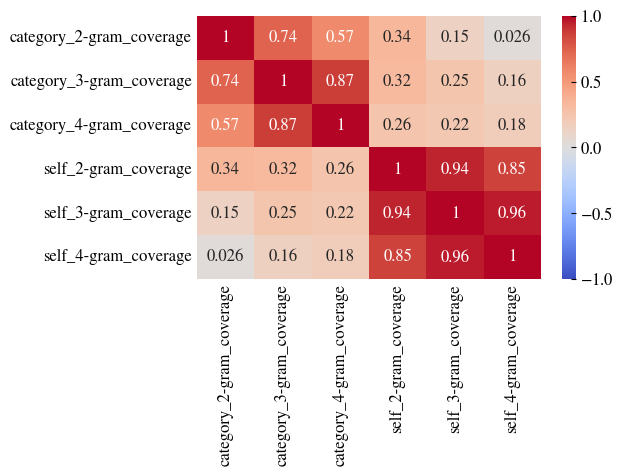

In [53]:
corr_matrix = df[
    [
        "category_2-gram_coverage",
        "category_3-gram_coverage",
        "category_4-gram_coverage",
        "self_2-gram_coverage",
        "self_3-gram_coverage",
        "self_4-gram_coverage",
    ]
].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

plt.grid(False)
plt.tick_params(axis="both", which="both", length=0, width=0)

plt.show()

# Do text measures and coverages correlate?

In [54]:
self_coverages = ["self_2-gram_coverage", "self_3-gram_coverage", "self_4-gram_coverage"]
category_coverages = ["category_2-gram_coverage", "category_3-gram_coverage", "category_4-gram_coverage"]

Self

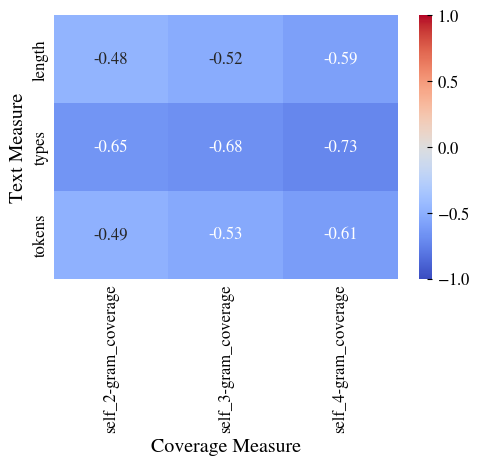

In [55]:
correlations = {}

for col in text_measures:
    df_subset = df[[col] + self_coverages]
    corr_matrix = df_subset.corr()
    correlations[col] = corr_matrix[col][self_coverages]

result_df = pd.DataFrame(correlations, index=self_coverages).transpose()

sns.heatmap(result_df, annot=True, cmap="coolwarm", fmt=".2f", center=0, vmin=-1, vmax=1)
plt.xlabel("Coverage Measure")
plt.ylabel("Text Measure")
plt.tick_params(axis="both", which="both", length=0, width=0)
plt.grid(False)
plt.show()

Category

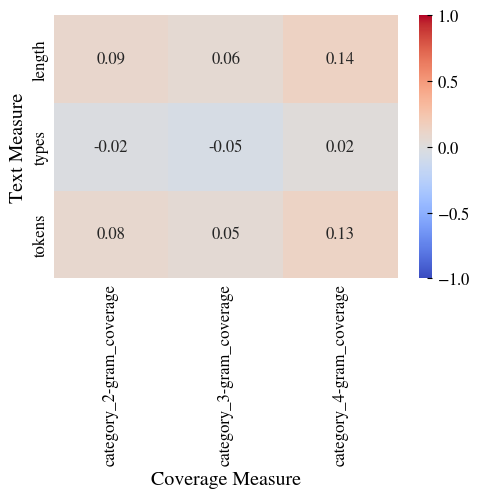

In [56]:
correlations = {}

for col in text_measures:
    df_subset = df[[col] + category_coverages]
    corr_matrix = df_subset.corr()
    correlations[col] = corr_matrix[col][category_coverages]

result_df = pd.DataFrame(correlations, index=category_coverages).transpose()

sns.heatmap(result_df, annot=True, cmap="coolwarm", fmt=".2f", center=0, vmin=-1, vmax=1)
plt.xlabel("Coverage Measure")
plt.ylabel("Text Measure")
plt.tick_params(axis="both", which="both", length=0, width=0)
plt.grid(False)
plt.show()

# Does formulaicity in charters change over time?

Focus is laid on charters; here, the full frame is taken

In [57]:
df_merged_nopunct_main = df_merged_nopunct[df_merged_nopunct["type"] == "main"]
df_merged_nopunct_main_inliers = df_merged_nopunct_main[df_merged_nopunct_main["tokens"] >= 100]

Calculate bins to know distribution

In [58]:
bins = pd.cut(df_merged_nopunct_main_inliers.year, bins=20)
bin_counts = pd.value_counts(bins, sort=False)
bin_counts

(1133.735, 1147.25]       1
(1147.25, 1160.5]         0
(1160.5, 1173.75]         0
(1173.75, 1187.0]         0
(1187.0, 1200.25]         0
(1200.25, 1213.5]         0
(1213.5, 1226.75]         1
(1226.75, 1240.0]         1
(1240.0, 1253.25]         1
(1253.25, 1266.5]         8
(1266.5, 1279.75]        24
(1279.75, 1293.0]       188
(1293.0, 1306.25]       533
(1306.25, 1319.5]       646
(1319.5, 1332.75]       806
(1332.75, 1346.0]      1083
(1346.0, 1359.25]      1158
(1359.25, 1372.5]      1030
(1372.5, 1385.75]      1182
(1385.75, 1399.0]       494
Name: year, dtype: int64

Given that the large majority of charters finds itself between 1300 and 1400, I limit them by these years.

In [59]:
filtered = df_merged_nopunct_main_inliers[
    (df_merged_nopunct_main_inliers["year"] >= 1300) & (df_merged_nopunct_main_inliers["year"] <= 1400)
].copy()

In [60]:
lr = filtered["text"].apply(LexicalRichness)
filtered["mtld"] = lr.progress_apply(lambda x: x.mtld(threshold=0.72))
filtered["hdd"] = lr.progress_apply(lambda x: x.hdd(draws=42))
filtered["Dugast"] = lr.progress_apply(lambda x: x.Dugast)
filtered["gzip_ratio"] = filtered["text"].progress_apply(lambda x: get_compression_ratio(x, "gzip"))

  0%|          | 0/6728 [00:00<?, ?it/s]

  0%|          | 0/6728 [00:00<?, ?it/s]

  0%|          | 0/6728 [00:00<?, ?it/s]

  0%|          | 0/6728 [00:00<?, ?it/s]

Create plain and interval-corrected sample

In [61]:
filtered_sample = filtered.sample(n=600, random_state=42)

In [62]:
n = 30
x_years = 5

filtered["year_interval"] = pd.cut(
    filtered["year"], bins=range(int(filtered["year"].min()), int(filtered["year"].max()) + x_years, x_years)
)
sample_size = n * len(filtered["year_interval"].unique())
samples_per_group = n
filtered_intervals = (
    filtered.groupby("year_interval").apply(lambda x: x.sample(samples_per_group, random_state=42)).reset_index(drop=True)
)

Show bins of full dataframe

In [63]:
bins = pd.cut(filtered.year, bins=20)
bin_counts = pd.value_counts(bins, sort=False)
bin_counts

(1299.901, 1304.95]    253
(1304.95, 1309.9]      201
(1309.9, 1314.85]      242
(1314.85, 1319.8]      279
(1319.8, 1324.75]      291
(1324.75, 1329.7]      300
(1329.7, 1334.65]      359
(1334.65, 1339.6]      346
(1339.6, 1344.55]      429
(1344.55, 1349.5]      452
(1349.5, 1354.45]      378
(1354.45, 1359.4]      492
(1359.4, 1364.35]      443
(1364.35, 1369.3]      390
(1369.3, 1374.25]      350
(1374.25, 1379.2]      604
(1379.2, 1384.15]      349
(1384.15, 1389.1]      322
(1389.1, 1394.05]      130
(1394.05, 1399.0]      118
Name: year, dtype: int64

Show bins of sample dataframe

In [64]:
bins = pd.cut(filtered_sample.year, bins=20)
bin_counts = pd.value_counts(bins, sort=False)
bin_counts

(1299.901, 1304.95]    26
(1304.95, 1309.9]      14
(1309.9, 1314.85]      22
(1314.85, 1319.8]      21
(1319.8, 1324.75]      35
(1324.75, 1329.7]      29
(1329.7, 1334.65]      32
(1334.65, 1339.6]      26
(1339.6, 1344.55]      38
(1344.55, 1349.5]      27
(1349.5, 1354.45]      42
(1354.45, 1359.4]      38
(1359.4, 1364.35]      41
(1364.35, 1369.3]      38
(1369.3, 1374.25]      30
(1374.25, 1379.2]      54
(1379.2, 1384.15]      34
(1384.15, 1389.1]      35
(1389.1, 1394.05]      10
(1394.05, 1399.0]       8
Name: year, dtype: int64

Show bins of interval dataframe

In [65]:
bins = pd.cut(filtered_intervals.year, bins=20)
bin_counts = pd.value_counts(bins, sort=False)
bin_counts

(1300.902, 1305.9]    30
(1305.9, 1310.8]      30
(1310.8, 1315.7]      30
(1315.7, 1320.6]      30
(1320.6, 1325.5]      30
(1325.5, 1330.4]      30
(1330.4, 1335.3]      30
(1335.3, 1340.2]      30
(1340.2, 1345.1]      30
(1345.1, 1350.0]      30
(1350.0, 1354.9]      26
(1354.9, 1359.8]      32
(1359.8, 1364.7]      31
(1364.7, 1369.6]      26
(1369.6, 1374.5]      28
(1374.5, 1379.4]      32
(1379.4, 1384.3]      26
(1384.3, 1389.2]      39
(1389.2, 1394.1]      27
(1394.1, 1399.0]      33
Name: year, dtype: int64

Generate line plots with rolling mean windows

GZIP

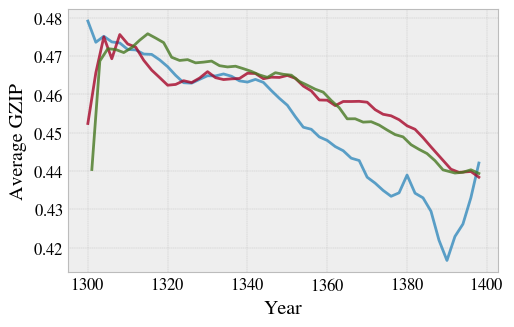

In [66]:
grouped_gzip_full = filtered.groupby("year")["gzip_ratio"].mean()
grouped_gzip_sample = filtered_sample.groupby("year")["gzip_ratio"].mean()
grouped_gzip_intervals = filtered_intervals.groupby("year")["gzip_ratio"].mean()

rolling_mean_gzip_full = grouped_gzip_full.rolling(window=10, step=2, min_periods=1).mean()
rolling_mean_gzip_sample = grouped_gzip_sample.rolling(window=50, step=2, min_periods=1).mean()
rolling_mean_gzip_intervals = grouped_gzip_intervals.rolling(window=50, step=2, min_periods=1).mean()

plt.plot(rolling_mean_gzip_full.index, rolling_mean_gzip_full.values, label="Full", alpha=0.8, color=colors[0])
plt.plot(rolling_mean_gzip_sample.index, rolling_mean_gzip_sample.values, label="Sample", alpha=0.8, color=colors[1])
plt.plot(
    rolling_mean_gzip_intervals.index,
    rolling_mean_gzip_intervals.values,
    label="Intervals",
    alpha=0.8,
    color=colors[3],
)

plt.xlabel("Year")
plt.ylabel("Average GZIP")
#plt.legend(bbox_to_anchor=(1.375, 0.5), loc="center right")
plt.savefig("../data-push/2-formulaicity/gzip-time.pdf", format="pdf", bbox_inches="tight")
plt.show()

MTLD

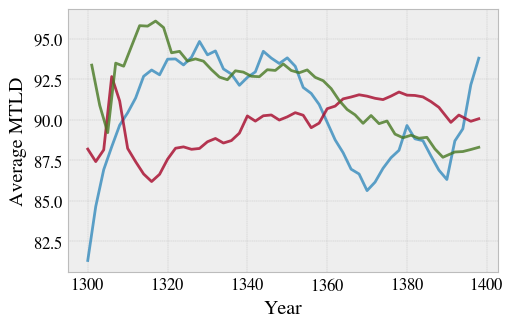

In [67]:
grouped_mtld_full = filtered.groupby("year")["mtld"].mean().rolling(window=10, step=2, min_periods=1).mean()
grouped_mtld_sample = filtered_sample.groupby("year")["mtld"].mean().rolling(window=50, step=2, min_periods=1).mean()
grouped_mtld_intervals = (
    filtered_intervals.groupby("year")["mtld"].mean().rolling(window=50, step=2, min_periods=1).mean()
)

plt.plot(grouped_mtld_full.index, grouped_mtld_full.values, label="Full", alpha=0.8, color=colors[0])
plt.plot(grouped_mtld_sample.index, grouped_mtld_sample.values, label="Sample", alpha=0.8, color=colors[1])
plt.plot(grouped_mtld_intervals.index, grouped_mtld_intervals.values, label="Intervals", alpha=0.8, color=colors[3])

plt.xlabel("Year")
plt.ylabel("Average MTLD")
#plt.legend(bbox_to_anchor=(1.375, 0.5), loc="center right")
plt.savefig("../data-push/2-formulaicity/mtld-time.pdf", format="pdf", bbox_inches="tight")
plt.show()

Dugast

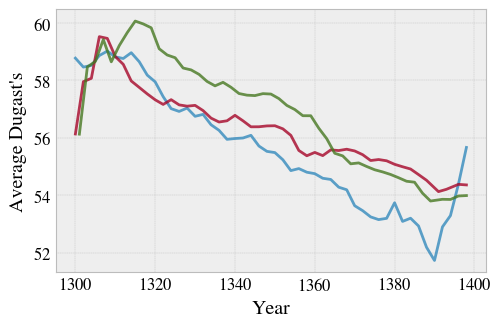

In [68]:
grouped_Dugast_full = filtered.groupby("year")["Dugast"].mean().rolling(window=10, step=2, min_periods=1).mean()
grouped_Dugast_sample = (
    filtered_sample.groupby("year")["Dugast"].mean().rolling(window=50, step=2, min_periods=1).mean()
)
grouped_Dugast_intervals = (
    filtered_intervals.groupby("year")["Dugast"].mean().rolling(window=50, step=2, min_periods=1).mean()
)

plt.plot(grouped_Dugast_full.index, grouped_Dugast_full.values, label="Full", alpha=0.8, color=colors[0])
plt.plot(grouped_Dugast_sample.index, grouped_Dugast_sample.values, label="Sample", alpha=0.8, color=colors[1])
plt.plot(
    grouped_Dugast_intervals.index, grouped_Dugast_intervals.values, label="Intervals", alpha=0.8, color=colors[3]
)

plt.xlabel("Year")
plt.ylabel("Average Dugast's")
#plt.legend(bbox_to_anchor=(1.375, 0.5), loc="center right")
plt.savefig("../data-push/2-formulaicity/dugast-time.pdf", format="pdf", bbox_inches="tight")
plt.savefig("../data-push/2-formulaicity/legend-crop.pdf", format="pdf", bbox_inches="tight")
plt.show()

Category coverages with lower window sizes

In [69]:
most_common = 10

For filtered (near full)

In [70]:
n = 2
category_ngrams = {}
for category, group in filtered.groupby("category"):
    aggregated_text = " ".join(group["text"].values)
    category_ngrams[category] = get_top_ngrams(aggregated_text, n, most_common)

filtered["category_2-gram_coverage"] = filtered.apply(
    lambda row: get_coverage_score(row["text"], category_ngrams[row["category"]]), axis=1)

n = 3
category_ngrams = {}
for category, group in filtered.groupby("category"):
    aggregated_text = " ".join(group["text"].values)
    category_ngrams[category] = get_top_ngrams(aggregated_text, n, most_common)

filtered["category_3-gram_coverage"] = filtered.apply(
    lambda row: get_coverage_score(row["text"], category_ngrams[row["category"]]), axis=1)

n = 4
category_ngrams = {}
for category, group in filtered.groupby("category"):
    aggregated_text = " ".join(group["text"].values)
    category_ngrams[category] = get_top_ngrams(aggregated_text, n, most_common)

filtered["category_4-gram_coverage"] = filtered.apply(
    lambda row: get_coverage_score(row["text"], category_ngrams[row["category"]]), axis=1)

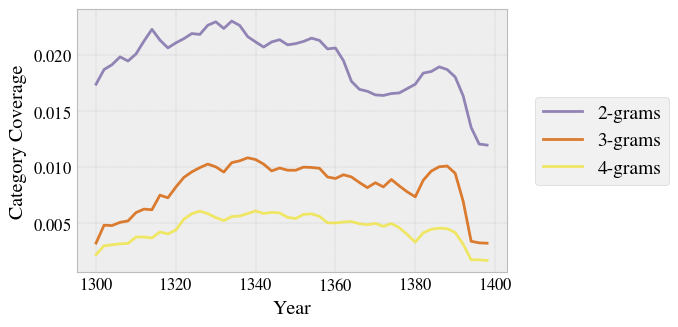

In [71]:
grouped_category_2_gram_coverage = (
    filtered.groupby("year")["category_2-gram_coverage"].mean().rolling(window=5, step=2, min_periods=1).mean()
)
grouped_category_3_gram_coverage = (
    filtered.groupby("year")["category_3-gram_coverage"].mean().rolling(window=5, step=2, min_periods=1).mean()
)
grouped_category_4_gram_coverage = (
    filtered.groupby("year")["category_4-gram_coverage"].mean().rolling(window=5, step=2, min_periods=1).mean()
)

plt.plot(
    grouped_category_2_gram_coverage.index,
    grouped_category_2_gram_coverage.values,
    label="2-grams",
    alpha=0.8,
    color=colors[2],
)
plt.plot(
    grouped_category_3_gram_coverage.index,
    grouped_category_3_gram_coverage.values,
    label="3-grams",
    alpha=0.8,
    color=colors[4],
)
plt.plot(
    grouped_category_4_gram_coverage.index,
    grouped_category_4_gram_coverage.values,
    label="4-grams",
    alpha=0.8,
    color=colors[8],
)

plt.xlabel("Year")
plt.ylabel("Category Coverage")
plt.legend(bbox_to_anchor=(1.4, 0.5), loc="center right")

plt.show()

For sample

In [72]:
n = 2
category_ngrams = {}
for category, group in filtered_sample.groupby("category"):
    aggregated_text = " ".join(group["text"].values)
    category_ngrams[category] = get_top_ngrams(aggregated_text, n, most_common)

filtered_sample["category_2-gram_coverage"] = filtered_sample.apply(
    lambda row: get_coverage_score(row["text"], category_ngrams[row["category"]]), axis=1)

n = 3
category_ngrams = {}
for category, group in filtered_sample.groupby("category"):
    aggregated_text = " ".join(group["text"].values)
    category_ngrams[category] = get_top_ngrams(aggregated_text, n, most_common)

filtered_sample["category_3-gram_coverage"] = filtered_sample.apply(
    lambda row: get_coverage_score(row["text"], category_ngrams[row["category"]]), axis=1)

n = 4
category_ngrams = {}
for category, group in filtered_sample.groupby("category"):
    aggregated_text = " ".join(group["text"].values)
    category_ngrams[category] = get_top_ngrams(aggregated_text, n, most_common)

filtered_sample["category_4-gram_coverage"] = filtered_sample.apply(
    lambda row: get_coverage_score(row["text"], category_ngrams[row["category"]]), axis=1)

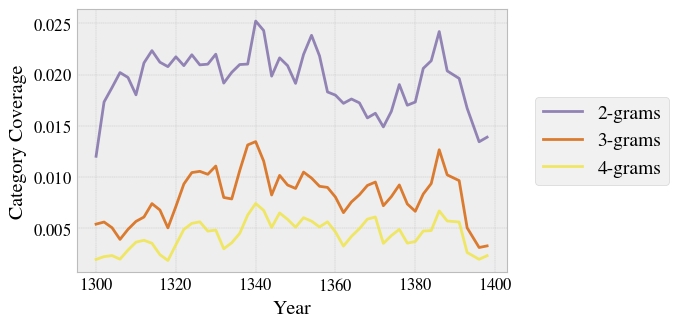

In [73]:
grouped_category_2_gram_coverage = (
    filtered_sample.groupby("year")["category_2-gram_coverage"].mean().rolling(window=5, step=2, min_periods=1).mean()
)
grouped_category_3_gram_coverage = (
    filtered_sample.groupby("year")["category_3-gram_coverage"].mean().rolling(window=5, step=2, min_periods=1).mean()
)
grouped_category_4_gram_coverage = (
    filtered_sample.groupby("year")["category_4-gram_coverage"].mean().rolling(window=5, step=2, min_periods=1).mean()
)

plt.plot(
    grouped_category_2_gram_coverage.index,
    grouped_category_2_gram_coverage.values,
    label="2-grams",
    alpha=0.8,
    color=colors[2],
)
plt.plot(
    grouped_category_3_gram_coverage.index,
    grouped_category_3_gram_coverage.values,
    label="3-grams",
    alpha=0.8,
    color=colors[4],
)
plt.plot(
    grouped_category_4_gram_coverage.index,
    grouped_category_4_gram_coverage.values,
    label="4-grams",
    alpha=0.8,
    color=colors[8],
)

plt.xlabel("Year")
plt.ylabel("Category Coverage")
plt.legend(bbox_to_anchor=(1.4, 0.5), loc="center right")

plt.show()

For intervals

In [74]:
n = 2
category_ngrams = {}
for category, group in filtered_intervals.groupby("category"):
    aggregated_text = " ".join(group["text"].values)
    category_ngrams[category] = get_top_ngrams(aggregated_text, n, most_common)

filtered_intervals["category_2-gram_coverage"] = filtered_intervals.apply(
    lambda row: get_coverage_score(row["text"], category_ngrams[row["category"]]), axis=1)

n = 3
category_ngrams = {}
for category, group in filtered_intervals.groupby("category"):
    aggregated_text = " ".join(group["text"].values)
    category_ngrams[category] = get_top_ngrams(aggregated_text, n, most_common)

filtered_intervals["category_3-gram_coverage"] = filtered_intervals.apply(
    lambda row: get_coverage_score(row["text"], category_ngrams[row["category"]]), axis=1)

n = 4
category_ngrams = {}
for category, group in filtered_intervals.groupby("category"):
    aggregated_text = " ".join(group["text"].values)
    category_ngrams[category] = get_top_ngrams(aggregated_text, n, most_common)

filtered_intervals["category_4-gram_coverage"] = filtered_intervals.apply(
    lambda row: get_coverage_score(row["text"], category_ngrams[row["category"]]), axis=1)

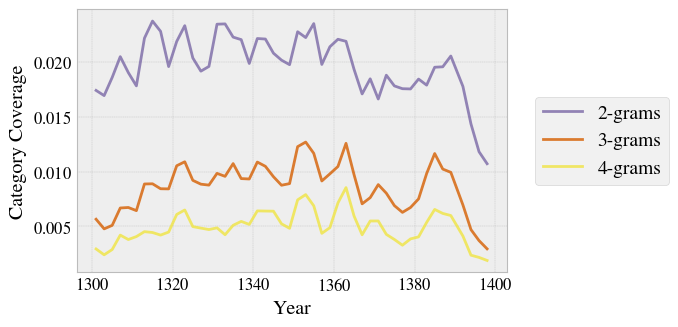

In [75]:
grouped_category_2_gram_coverage = (
    filtered_intervals.groupby("year")["category_2-gram_coverage"].mean().rolling(window=5, step=2, min_periods=1).mean()
)
grouped_category_3_gram_coverage = (
    filtered_intervals.groupby("year")["category_3-gram_coverage"].mean().rolling(window=5, step=2, min_periods=1).mean()
)
grouped_category_4_gram_coverage = (
    filtered_intervals.groupby("year")["category_4-gram_coverage"].mean().rolling(window=5, step=2, min_periods=1).mean()
)

plt.plot(
    grouped_category_2_gram_coverage.index,
    grouped_category_2_gram_coverage.values,
    label="2-grams",
    alpha=0.8,
    color=colors[2],
)
plt.plot(
    grouped_category_3_gram_coverage.index,
    grouped_category_3_gram_coverage.values,
    label="3-grams",
    alpha=0.8,
    color=colors[4],
)
plt.plot(
    grouped_category_4_gram_coverage.index,
    grouped_category_4_gram_coverage.values,
    label="4-grams",
    alpha=0.8,
    color=colors[8],
)

plt.xlabel("Year")
plt.ylabel("Category Coverage")
plt.legend(bbox_to_anchor=(1.4, 0.5), loc="center right")

plt.show()

Comparing set, sample, intervals of grams with same window sizes

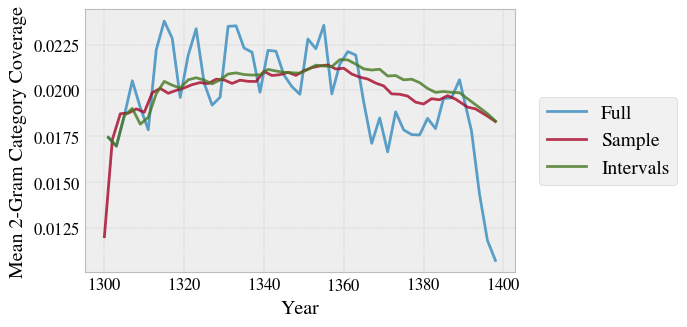

In [76]:
grouped_category_2_gram_coverage_full = (
    filtered.groupby("year")["category_2-gram_coverage"].mean().rolling(window=10, step=2, min_periods=1).mean()
)
grouped_category_2_gram_coverage_sample = (
    filtered_sample.groupby("year")["category_2-gram_coverage"].mean().rolling(window=50, step=2, min_periods=1).mean()
)
grouped_category_2_gram_coverage_intervals = (
    filtered_intervals.groupby("year")["category_2-gram_coverage"].mean().rolling(window=50, step=2, min_periods=1).mean()
)

plt.plot(
    grouped_category_2_gram_coverage.index,
    grouped_category_2_gram_coverage.values,
    label="Full",
    alpha=0.8,
    color=colors[0],
)
plt.plot(
    grouped_category_2_gram_coverage_sample.index,
    grouped_category_2_gram_coverage_sample.values,
    label="Sample",
    alpha=0.8,
    color=colors[1],
)
plt.plot(
    grouped_category_2_gram_coverage_intervals.index,
    grouped_category_2_gram_coverage_intervals.values,
    label="Intervals",
    alpha=0.8,
    color=colors[3],
)

plt.xlabel("Year")
plt.ylabel("Mean 2-Gram Category Coverage")
plt.legend(bbox_to_anchor=(1.4, 0.5), loc="center right")
plt.show()

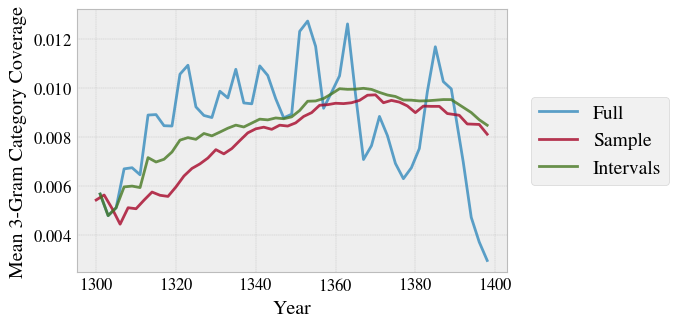

In [77]:
grouped_category_3_gram_coverage_full = (
    filtered.groupby("year")["category_3-gram_coverage"].mean().rolling(window=10, step=2, min_periods=1).mean()
)
grouped_category_3_gram_coverage_sample = (
    filtered_sample.groupby("year")["category_3-gram_coverage"].mean().rolling(window=50, step=2, min_periods=1).mean()
)
grouped_category_3_gram_coverage_intervals = (
    filtered_intervals.groupby("year")["category_3-gram_coverage"].mean().rolling(window=50, step=2, min_periods=1).mean()
)

plt.plot(
    grouped_category_3_gram_coverage.index,
    grouped_category_3_gram_coverage.values,
    label="Full",
    alpha=0.8,
    color=colors[0],
)
plt.plot(
    grouped_category_3_gram_coverage_sample.index,
    grouped_category_3_gram_coverage_sample.values,
    label="Sample",
    alpha=0.8,
    color=colors[1],
)
plt.plot(
    grouped_category_3_gram_coverage_intervals.index,
    grouped_category_3_gram_coverage_intervals.values,
    label="Intervals",
    alpha=0.8,
    color=colors[3],
)

plt.xlabel("Year")
plt.ylabel("Mean 3-Gram Category Coverage")
plt.savefig("../data-push/2-formulaicity/3-gram-cat-cov-time.pdf", format="pdf", bbox_inches="tight")
plt.legend(bbox_to_anchor=(1.4, 0.5), loc="center right")
plt.show()

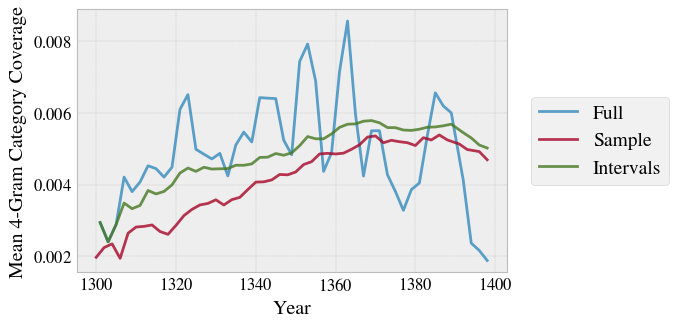

In [78]:
grouped_category_4_gram_coverage_full = (
    filtered.groupby("year")["category_4-gram_coverage"].mean().rolling(window=10, step=2, min_periods=1).mean()
)
grouped_category_4_gram_coverage_sample = (
    filtered_sample.groupby("year")["category_4-gram_coverage"].mean().rolling(window=50, step=2, min_periods=1).mean()
)
grouped_category_4_gram_coverage_intervals = (
    filtered_intervals.groupby("year")["category_4-gram_coverage"].mean().rolling(window=50, step=2, min_periods=1).mean()
)

plt.plot(
    grouped_category_4_gram_coverage.index,
    grouped_category_4_gram_coverage.values,
    label="Full",
    alpha=0.8,
    color=colors[0],
)
plt.plot(
    grouped_category_4_gram_coverage_sample.index,
    grouped_category_4_gram_coverage_sample.values,
    label="Sample",
    alpha=0.8,
    color=colors[1],
)
plt.plot(
    grouped_category_4_gram_coverage_intervals.index,
    grouped_category_4_gram_coverage_intervals.values,
    label="Intervals",
    alpha=0.8,
    color=colors[3],
)

plt.xlabel("Year")
plt.ylabel("Mean 4-Gram Category Coverage")
plt.legend(bbox_to_anchor=(1.4, 0.5), loc="center right")
plt.show()